In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

In [0]:
nhs_suppliers_df = spark.read.table('my_catalog.bsheffield_spark.nhs_suppliers')
nhs_contract_description = spark.read.table('my_catalog.bsheffield_spark.nhs_contract_description')
nhs_trusts = spark.read.table('my_catalog.bsheffield_spark.nhs_trusts')
nhs_deliveries = spark.read.table('my_catalog.bsheffield_spark.nhs_deliveries')
nhs_costs_df = spark.read.table('my_catalog.bsheffield_spark.contracts_cost')

In [0]:
nhs_combo_df = nhs_suppliers_df \
    .select('supplier_id', 'supplier_name') \
    .join(nhs_contract_description, on='supplier_id', how='inner') \
    .join(nhs_trusts.select('trust_id', 'trust_name'), on='trust_id', how='inner') \
    .join(nhs_deliveries, on='contract_id', how='inner') \
    .join(nhs_costs_df, on='contract_id', how='inner')

In [0]:
nhs_combo_df.printSchema()

root
 |-- contract_id: string (nullable = true)
 |-- trust_id: string (nullable = true)
 |-- supplier_id: string (nullable = true)
 |-- supplier_name: string (nullable = true)
 |-- contract_type_id: string (nullable = true)
 |-- contract_type: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- issue_date: date (nullable = true)
 |-- closing_date: date (nullable = true)
 |-- trust_name: string (nullable = true)
 |-- quoted_lead_days: long (nullable = true)
 |-- actual_lead_days: long (nullable = true)
 |-- delivery_date: date (nullable = true)
 |-- quantity: long (nullable = true)
 |-- unit_cost: double (nullable = true)
 |-- quoted_cost: double (nullable = true)
 |-- actual_cost: double (nullable = true)
 |-- cost_overrun: double (nullable = true)



In [0]:
display(nhs_combo_df.limit(5))

contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun
NHS-CT-00001,TR-002,SUP-001,MedSupply UK,CTYP-006,Sharps Disposal,L9,2024-12-06,2024-12-31,Liverpool University Hospitals NHS FT,14,19,2025-01-19,100000,0.51,51101.26,51101.51,0.26
NHS-CT-00002,TR-005,SUP-002,BioLogica Ltd,CTYP-004,Reagent Bundles,FY3,2024-10-08,2024-10-19,Blackpool Teaching Hospitals NHS FT,29,34,2024-11-22,150,611.63,91745.0,92050.81,305.82
NHS-CT-00003,TR-002,SUP-002,BioLogica Ltd,CTYP-003,PCR Test Kits,L9,2025-03-30,2025-04-25,Liverpool University Hospitals NHS FT,15,15,2025-05-10,2000,11.88,23762.2,23762.2,0.0
NHS-CT-00004,TR-005,SUP-005,SterileFlow,CTYP-006,Sharps Disposal,FY1,2024-04-02,2024-04-24,Blackpool Teaching Hospitals NHS FT,10,13,2024-05-07,25000,0.38,9574.31,9574.42,0.11
NHS-CT-00005,TR-004,SUP-004,HealthLab Partners,CTYP-004,Reagent Bundles,PR2,2025-01-01,2025-01-17,Lancashire Teaching Hospitals NHS FT,14,16,2025-02-02,75,418.6,31394.96,31478.68,83.72


In [0]:
nhs_combo_df.select("trust_id").agg(F.countDistinct("trust_id")).show()
nhs_combo_df.select("supplier_id").agg(F.countDistinct("supplier_id")).show()

+------------------------+
|count(DISTINCT trust_id)|
+------------------------+
|                       5|
+------------------------+

+---------------------------+
|count(DISTINCT supplier_id)|
+---------------------------+
|                          5|
+---------------------------+



Need to examine:
1. Date/Time for issue date and closing date for contract (months/week number _?/Seasonality)
2. Encoding Postcode/Location of Delivery 
3. Encoding Contract Type 
4. Encoding Trust_id/name?

In [0]:
nhs_combo_df_pandas = nhs_combo_df.toPandas()

In [0]:
nhs_combo_df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   contract_id       1000 non-null   object 
 1   trust_id          1000 non-null   object 
 2   supplier_id       1000 non-null   object 
 3   supplier_name     1000 non-null   object 
 4   contract_type_id  1000 non-null   object 
 5   contract_type     1000 non-null   object 
 6   postcode          1000 non-null   object 
 7   issue_date        1000 non-null   object 
 8   closing_date      1000 non-null   object 
 9   trust_name        1000 non-null   object 
 10  quoted_lead_days  1000 non-null   int64  
 11  actual_lead_days  1000 non-null   int64  
 12  delivery_date     1000 non-null   object 
 13  quantity          1000 non-null   int64  
 14  unit_cost         1000 non-null   float64
 15  quoted_cost       1000 non-null   float64
 16  actual_cost       1000 non-null   float64
 

In [0]:
nhs_combo_df_pandas.sample(4)

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun
143,NHS-CT-00144,TR-001,SUP-003,NorthWest Diagnostics,CTYP-004,Reagent Bundles,M14,2025-02-21,2025-03-19,Manchester University NHS FT,15,15,2025-04-03,50,448.86,22443.12,22443.12,0.00
338,NHS-CT-00339,TR-002,SUP-002,BioLogica Ltd,CTYP-006,Sharps Disposal,L7,2024-11-21,2024-12-16,Liverpool University Hospitals NHS FT,11,11,2024-12-27,50000,0.55,27444.56,27444.56,0.00
413,NHS-CT-00414,TR-001,SUP-002,BioLogica Ltd,CTYP-005,Pipette Tips,M13,2024-12-13,2024-12-24,Manchester University NHS FT,4,5,2024-12-29,100000,0.04,4328.51,4328.52,0.00
931,NHS-CT-00932,TR-005,SUP-002,BioLogica Ltd,CTYP-005,Pipette Tips,FY3,2024-09-27,2024-10-14,Blackpool Teaching Hospitals NHS FT,6,7,2024-10-21,50000,0.07,3322.99,3323.00,0.01


In [0]:
import random
from datetime import datetime, timedelta

nhs_combo_df_pandas['issue_date'] = pd.to_datetime(nhs_combo_df_pandas['issue_date'], errors='coerce')
nhs_combo_df_pandas['closing_date'] = pd.to_datetime(nhs_combo_df_pandas['closing_date'], errors='coerce')
nhs_combo_df_pandas['delivery_date'] = pd.to_datetime(nhs_combo_df_pandas['delivery_date'], errors='coerce')

In [0]:
nhs_combo_df_pandas['closing_date_month'] = nhs_combo_df_pandas['closing_date'].dt.month_name()

In [0]:
nhs_combo_df_pandas.sample()

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun,closing_date_month
472,NHS-CT-00473,TR-004,SUP-005,SterileFlow,CTYP-006,Sharps Disposal,PR2,2024-07-15,2024-08-04,Lancashire Teaching Hospitals NHS FT,14,18,2024-08-22,25000,0.26,6580.22,6580.33,0.11,August


In [0]:
nhs_combo_df_pandas['contract_type_id'].value_counts()

contract_type_id
CTYP-004    180
CTYP-005    180
CTYP-006    178
CTYP-002    163
CTYP-001    157
CTYP-003    142
Name: count, dtype: int64

Need to decide what predicting 
1. Predicting likelihood to be undervalued/overpriced
2. Predicting days to arrive

In [0]:
nhs_combo_df_pandas.sample()

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun,closing_date_month
177,NHS-CT-00178,TR-005,SUP-004,HealthLab Partners,CTYP-002,Urine/Stool Sample Kits,FY1,2024-07-22,2024-08-09,Blackpool Teaching Hospitals NHS FT,8,14,2024-08-23,5000,0.55,2770.45,2770.78,0.33,August


In [0]:
nhs_combo_df_pandas['actual_per_unit_cost'] = nhs_combo_df_pandas['actual_cost']/nhs_combo_df_pandas['quantity']
nhs_combo_df_pandas['quoted_per_unit_cost'] = nhs_combo_df_pandas['quoted_cost']/nhs_combo_df_pandas['quantity']

In [0]:
nhs_combo_df_pandas.sample()

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun,closing_date_month,actual_per_unit_cost,quoted_per_unit_cost
112,NHS-CT-00113,TR-005,SUP-002,BioLogica Ltd,CTYP-006,Sharps Disposal,FY3,2024-06-02,2024-06-28,Blackpool Teaching Hospitals NHS FT,10,11,2024-07-09,25000,0.48,12057.0,12057.05,0.05,June,0.482282,0.48228


In [0]:
# calculate probability of being undervalued/overpriced?
nhs_combo_df_pandas['cost_deviation_pct'] = ((nhs_combo_df_pandas['actual_cost']- nhs_combo_df_pandas['quoted_cost'])/nhs_combo_df_pandas['quoted_cost']) * 100

In [0]:
nhs_combo_df_pandas.sample(10)

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun,closing_date_month,actual_per_unit_cost,quoted_per_unit_cost,cost_deviation_pct
894,NHS-CT-00895,TR-002,SUP-002,BioLogica Ltd,CTYP-002,Urine/Stool Sample Kits,L9,2024-05-20,2024-06-11,Liverpool University Hospitals NHS FT,14,14,2024-06-25,15000,0.55,8227.82,8227.82,0.00,June,0.548521,0.548521,0.000000
30,NHS-CT-00031,TR-001,SUP-005,SterileFlow,CTYP-006,Sharps Disposal,M15,2024-10-28,2024-11-20,Manchester University NHS FT,11,12,2024-12-02,50000,0.23,11701.26,11701.29,0.02,November,0.234026,0.234025,0.000256
283,NHS-CT-00284,TR-004,SUP-003,NorthWest Diagnostics,CTYP-002,Urine/Stool Sample Kits,PR2,2024-11-27,2024-12-13,Lancashire Teaching Hospitals NHS FT,12,18,2024-12-31,5000,0.65,3241.11,3241.50,0.39,December,0.648300,0.648222,0.012033
937,NHS-CT-00938,TR-001,SUP-003,NorthWest Diagnostics,CTYP-004,Reagent Bundles,M14,2024-08-14,2024-09-08,Manchester University NHS FT,30,30,2024-10-08,75,318.79,23908.88,23908.88,0.00,September,318.785067,318.785067,0.000000
713,NHS-CT-00714,TR-005,SUP-005,SterileFlow,CTYP-003,PCR Test Kits,FY1,2025-02-04,2025-03-01,Blackpool Teaching Hospitals NHS FT,20,22,2025-03-23,5000,11.52,57608.92,57611.23,2.30,March,11.522246,11.521784,0.004010
33,NHS-CT-00034,TR-005,SUP-001,MedSupply UK,CTYP-004,Reagent Bundles,FY3,2025-03-17,2025-04-07,Blackpool Teaching Hospitals NHS FT,27,31,2025-05-08,50,417.46,20872.91,21039.89,166.98,April,420.797800,417.458200,0.799984
849,NHS-CT-00850,TR-001,SUP-005,SterileFlow,CTYP-004,Reagent Bundles,M15,2024-04-14,2024-05-13,Manchester University NHS FT,10,10,2024-05-23,75,433.63,32522.19,32522.19,0.00,May,433.629200,433.629200,0.000000
526,NHS-CT-00527,TR-005,SUP-003,NorthWest Diagnostics,CTYP-005,Pipette Tips,FY1,2024-07-18,2024-08-14,Blackpool Teaching Hospitals NHS FT,6,8,2024-08-22,50000,0.08,3886.27,3886.29,0.02,August,0.077726,0.077725,0.000515
11,NHS-CT-00012,TR-004,SUP-001,MedSupply UK,CTYP-004,Reagent Bundles,PR2,2025-01-12,2025-01-28,Lancashire Teaching Hospitals NHS FT,28,33,2025-03-02,50,438.54,21927.12,22146.39,219.27,January,442.927800,438.542400,0.999995
631,NHS-CT-00632,TR-003,SUP-003,NorthWest Diagnostics,CTYP-004,Reagent Bundles,CH1,2025-01-22,2025-02-19,Cheshire & Merseyside NHS FT,26,28,2025-03-19,150,254.37,38155.91,38206.78,50.87,February,254.711867,254.372733,0.133321


<Axes: xlabel='actual_cost', ylabel='cost_deviation_pct'>

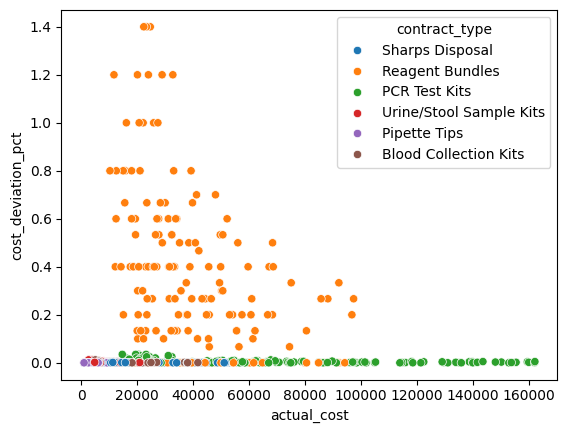

In [0]:
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

sns.scatterplot(x='actual_cost', y='cost_deviation_pct', hue='contract_type', data=nhs_combo_df_pandas)

In [0]:
nhs_combo_df_pandas['contract_type'].value_counts()

contract_type
Reagent Bundles            180
Pipette Tips               180
Sharps Disposal            178
Urine/Stool Sample Kits    163
Blood Collection Kits      157
PCR Test Kits              142
Name: count, dtype: int64

<Axes: xlabel='quoted_cost', ylabel='cost_deviation_pct'>

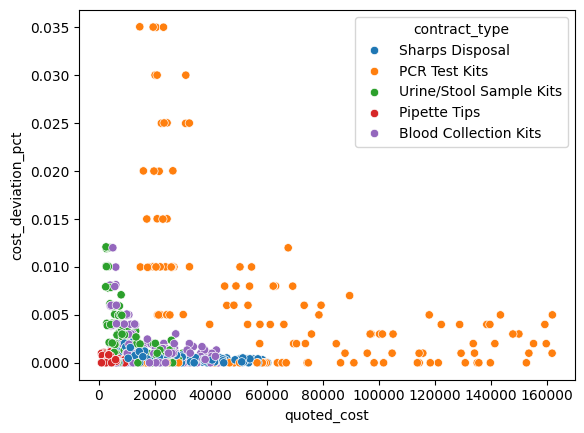

In [0]:
contract_types = ['Sharps Disposal', 'Pipette Tips', 'Urine/Stool Sample Kits', 'Blood Collection Kits', 'PCR Test Kits']

filtered_df = nhs_combo_df_pandas[nhs_combo_df_pandas['contract_type'].isin(contract_types)]

sns.scatterplot(y='cost_deviation_pct', x='quoted_cost', hue='contract_type', data=filtered_df)

In [0]:
nhs_combo_df_pandas.sample()

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun,closing_date_month,actual_per_unit_cost,quoted_per_unit_cost,cost_deviation_pct
947,NHS-CT-00948,TR-001,SUP-002,BioLogica Ltd,CTYP-006,Sharps Disposal,M14,2024-07-03,2024-07-15,Manchester University NHS FT,11,16,2024-07-31,100000,0.52,51503.07,51503.33,0.26,July,0.515033,0.515031,0.000505


<Axes: xlabel='postcode', ylabel='cost_deviation_pct'>

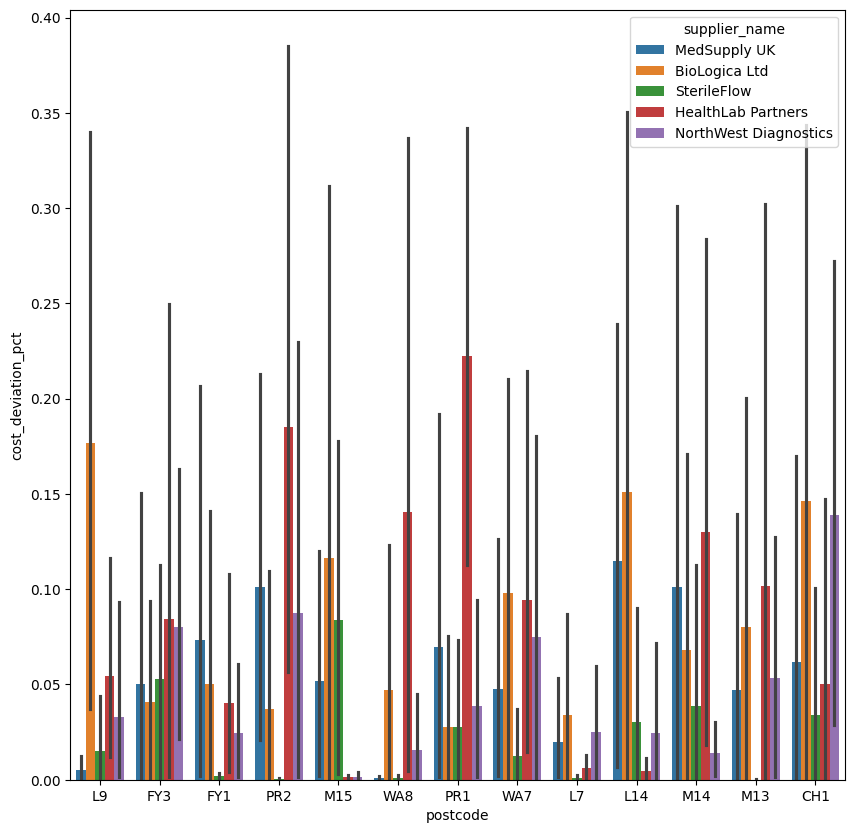

In [0]:
plt.figure(figsize=(10,10))
sns.barplot(x='postcode', y='cost_deviation_pct', hue='supplier_name',data=nhs_combo_df_pandas)

<Axes: xlabel='cost_deviation_pct', ylabel='supplier_name'>

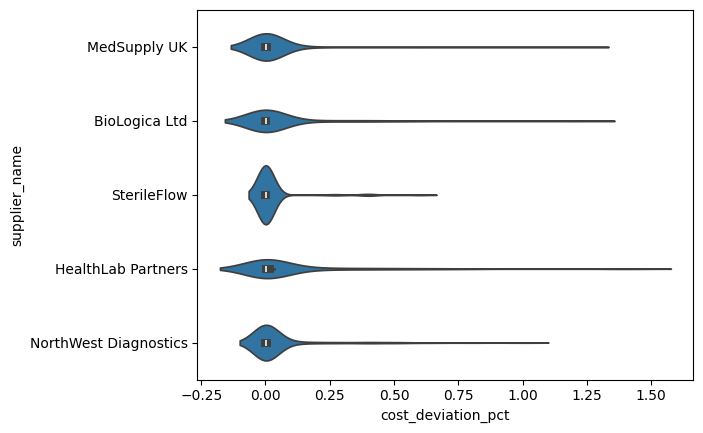

In [0]:
sns.violinplot(x='cost_deviation_pct', y='supplier_name',data=nhs_combo_df_pandas)

In [0]:
nhs_combo_df_pandas['cost_deviation_pct'].min()

np.float64(0.0)

<Axes: xlabel='cost_deviation_pct', ylabel='supplier_name'>

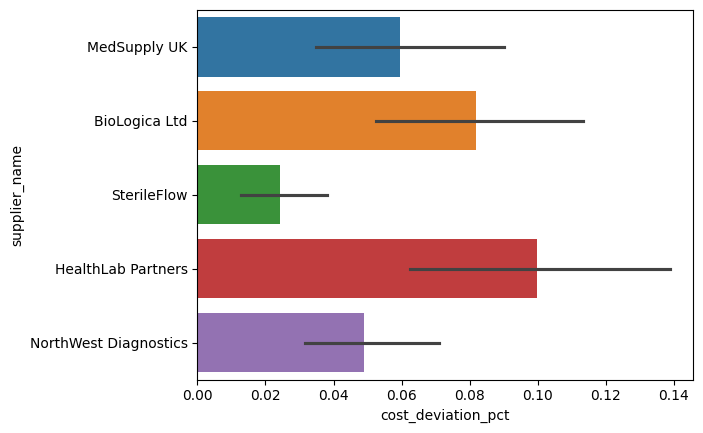

In [0]:
sns.barplot(x='cost_deviation_pct', y='supplier_name',hue='supplier_name', data=nhs_combo_df_pandas)

### Pipeline (Preprocessing Basic)

In [0]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output='pandas')

Spring: March, April, May
Summer: June, July, August
Autumn: September, October, November
Winter: December, January, February 

In [0]:
def assign_season(month):
    if month in ("March", "April", "May"):
        return "Spring"
    elif month in ("June", "July", "August"):
        return "Summer"
    elif month in ("September", "October", "November"):
        return "Autumn"
    else:
        return "Winter"

nhs_combo_df_pandas['closing_date_season'] = nhs_combo_df_pandas['closing_date_month'].apply(assign_season)

In [0]:
nhs_combo_df_pandas['closing_date_month'].value_counts()

closing_date_month
August       103
October       93
January       92
December      90
May           85
July          84
April         82
March         82
November      80
June          80
September     72
February      57
Name: count, dtype: int64

In [0]:
nhs_combo_df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   contract_id           1000 non-null   object        
 1   trust_id              1000 non-null   object        
 2   supplier_id           1000 non-null   object        
 3   supplier_name         1000 non-null   object        
 4   contract_type_id      1000 non-null   object        
 5   contract_type         1000 non-null   object        
 6   postcode              1000 non-null   object        
 7   issue_date            1000 non-null   datetime64[ns]
 8   closing_date          1000 non-null   datetime64[ns]
 9   trust_name            1000 non-null   object        
 10  quoted_lead_days      1000 non-null   int64         
 11  actual_lead_days      1000 non-null   int64         
 12  delivery_date         1000 non-null   datetime64[ns]
 13  quantity           

In [0]:
nhs_combo_df_pandas.sample()

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun,closing_date_month,actual_per_unit_cost,quoted_per_unit_cost,cost_deviation_pct,closing_date_season
73,NHS-CT-00074,TR-003,SUP-001,MedSupply UK,CTYP-004,Reagent Bundles,CH1,2025-01-17,2025-01-25,Cheshire & Merseyside NHS FT,12,16,2025-02-10,75,352.41,26430.66,26571.63,140.96,January,354.2884,352.4088,0.533358,Winter


In [0]:
def avg_actual_price_until_row(row, df):
    mask = (df['contract_type'] == row['contract_type']) & (df['closing_date'] <= row['closing_date'])
    return df.loc[mask, 'actual_cost'].mean()

nhs_combo_df_pandas['avg_actual_cost_until_closing_date'] = nhs_combo_df_pandas.apply(
    lambda row: avg_actual_price_until_row(row, nhs_combo_df_pandas), axis=1
)

In [0]:
nhs_combo_df_pandas.sample(2)

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun,closing_date_month,actual_per_unit_cost,quoted_per_unit_cost,cost_deviation_pct,closing_date_season,avg_actual_cost_until_closing_date
177,NHS-CT-00178,TR-005,SUP-004,HealthLab Partners,CTYP-002,Urine/Stool Sample Kits,FY1,2024-07-22,2024-08-09,Blackpool Teaching Hospitals NHS FT,8,14,2024-08-23,5000,0.55,2770.45,2770.78,0.33,August,0.554156,0.554090,0.011911,Summer,10788.194884
694,NHS-CT-00695,TR-005,SUP-005,SterileFlow,CTYP-001,Blood Collection Kits,FY3,2024-12-27,2025-01-17,Blackpool Teaching Hospitals NHS FT,10,10,2025-01-27,30000,1.01,30331.30,30331.30,0.00,January,1.011043,1.011043,0.000000,Winter,18115.261639


In [0]:
cat_feat = ['contract_type', 'postcode', 'closing_date_season', 'supplier_name']
num_feat = ['quantity', 'avg_actual_cost_until_closing_date', 'quoted_per_unit_cost', 'quoted_cost', 'actual_per_unit_cost']
X = nhs_combo_df_pandas[cat_feat +  num_feat]
y= nhs_combo_df_pandas['cost_deviation_pct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [0]:
season_means = X_train.groupby('closing_date_season')['actual_per_unit_cost'].mean()
X_train['actual_per_unit_closing_season'] = X_train['closing_date_season'].map(season_means)
X_test['actual_per_unit_closing_season'] = X_test['closing_date_season'].map(season_means)
X_test.drop(columns=['actual_per_unit_cost'])

,contract_type,postcode,closing_date_season,supplier_name,quantity,avg_actual_cost_until_closing_date,quoted_per_unit_cost,quoted_cost,actual_per_unit_closing_season
754,Reagent Bundles,WA8,Winter,HealthLab Partners,150,40964.911212,395.927800,59389.17,91.219502
768,Urine/Stool Sample Kits,WA8,Autumn,NorthWest Diagnostics,30000,10646.701525,0.541964,16258.93,80.050568
23,Urine/Stool Sample Kits,FY3,Summer,NorthWest Diagnostics,15000,11128.358049,0.556211,8343.16,64.615709
47,Urine/Stool Sample Kits,FY1,Autumn,MedSupply UK,15000,10529.383623,1.019266,15288.99,80.050568
453,Urine/Stool Sample Kits,PR1,Summer,SterileFlow,15000,11742.099706,0.871425,13071.37,64.615709
...,...,...,...,...,...,...,...,...,...
480,Sharps Disposal,FY3,Winter,BioLogica Ltd,100000,24854.249803,0.257460,25745.99,91.219502
992,PCR Test Kits,FY1,Winter,BioLogica Ltd,10000,67312.271389,13.577016,135770.16,91.219502
783,PCR Test Kits,CH1,Autumn,MedSupply UK,5000,70357.799012,9.661042,48305.21,80.050568
201,Sharps Disposal,L9,Autumn,BioLogica Ltd,50000,24770.967949,0.530734,26536.70,80.050568


In [0]:
contract_means = X_train.groupby('contract_type')['actual_per_unit_cost'].mean()
X_train['actual_per_unit_contract'] = X_train['contract_type'].map(contract_means)
X_test['actual_per_unit_contract'] = X_test['contract_type'].map(contract_means)
X_test.drop(columns=['actual_per_unit_cost'])

,contract_type,postcode,closing_date_season,supplier_name,quantity,avg_actual_cost_until_closing_date,quoted_per_unit_cost,quoted_cost,actual_per_unit_closing_season,actual_per_unit_contract
754,Reagent Bundles,WA8,Winter,HealthLab Partners,150,40964.911212,395.927800,59389.17,91.219502,432.505945
768,Urine/Stool Sample Kits,WA8,Autumn,NorthWest Diagnostics,30000,10646.701525,0.541964,16258.93,80.050568,0.758651
23,Urine/Stool Sample Kits,FY3,Summer,NorthWest Diagnostics,15000,11128.358049,0.556211,8343.16,64.615709,0.758651
47,Urine/Stool Sample Kits,FY1,Autumn,MedSupply UK,15000,10529.383623,1.019266,15288.99,80.050568,0.758651
453,Urine/Stool Sample Kits,PR1,Summer,SterileFlow,15000,11742.099706,0.871425,13071.37,64.615709,0.758651
...,...,...,...,...,...,...,...,...,...,...
480,Sharps Disposal,FY3,Winter,BioLogica Ltd,100000,24854.249803,0.257460,25745.99,91.219502,0.403393
992,PCR Test Kits,FY1,Winter,BioLogica Ltd,10000,67312.271389,13.577016,135770.16,91.219502,11.757619
783,PCR Test Kits,CH1,Autumn,MedSupply UK,5000,70357.799012,9.661042,48305.21,80.050568,11.757619
201,Sharps Disposal,L9,Autumn,BioLogica Ltd,50000,24770.967949,0.530734,26536.70,80.050568,0.403393


In [0]:
X_train.sample(3)

,contract_type,postcode,closing_date_season,supplier_name,quantity,avg_actual_cost_until_closing_date,quoted_per_unit_cost,quoted_cost,actual_per_unit_cost,actual_per_unit_closing_season,actual_per_unit_contract
458,Sharps Disposal,WA8,Summer,MedSupply UK,100000,24561.918250,0.511281,51128.14,0.511281,64.615709,0.403393
90,Urine/Stool Sample Kits,CH1,Winter,SterileFlow,15000,11028.881942,0.620345,9305.18,0.620345,91.219502,0.758651
4,Reagent Bundles,PR2,Winter,HealthLab Partners,75,40795.913000,418.599467,31394.96,419.715733,91.219502,432.505945


In [0]:
X_train.sample()

,contract_type,postcode,closing_date_season,supplier_name,quantity,avg_actual_cost_until_closing_date,quoted_per_unit_cost,quoted_cost,actual_per_unit_cost,actual_per_unit_closing_season,actual_per_unit_contract
281,Urine/Stool Sample Kits,M13,Summer,HealthLab Partners,10000,10562.150222,0.803868,8038.68,0.803925,64.615709,0.758651


In [0]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_feat),
        ("num", numerical_transformer, num_feat)
    ]
)

In [0]:
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['contract_type', 'postcode',
                                  'closing_date_season', 'supplier_name']),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['quantity',
                                  'avg_actual_cost_until_closing_date',
                                  'quoted_per_unit_cost', 'quoted_cost',
                                  'actual_per_unit_cost'])])

In [0]:
X.sample()

,contract_type,postcode,closing_date_season,supplier_name,quantity,avg_actual_cost_until_closing_date,quoted_per_unit_cost,quoted_cost,actual_per_unit_cost
763,Urine/Stool Sample Kits,L9,Winter,BioLogica Ltd,15000,11195.850385,0.980933,14714.0,0.98094


In [0]:
X_num_encoded = numerical_transformer.fit_transform(X[num_feat])

In [0]:
X_num_encoded.sample()

,quantity,avg_actual_cost_until_closing_date,quoted_per_unit_cost,quoted_cost,actual_per_unit_cost
538,0.066355,0.811922,0.019755,0.833294,0.019677


### Correlation Matrices

In [0]:
num_target_df = pd.concat([X_num_encoded, y], axis=1)

Text(0.5, 1.0, 'Correlation Matrix')

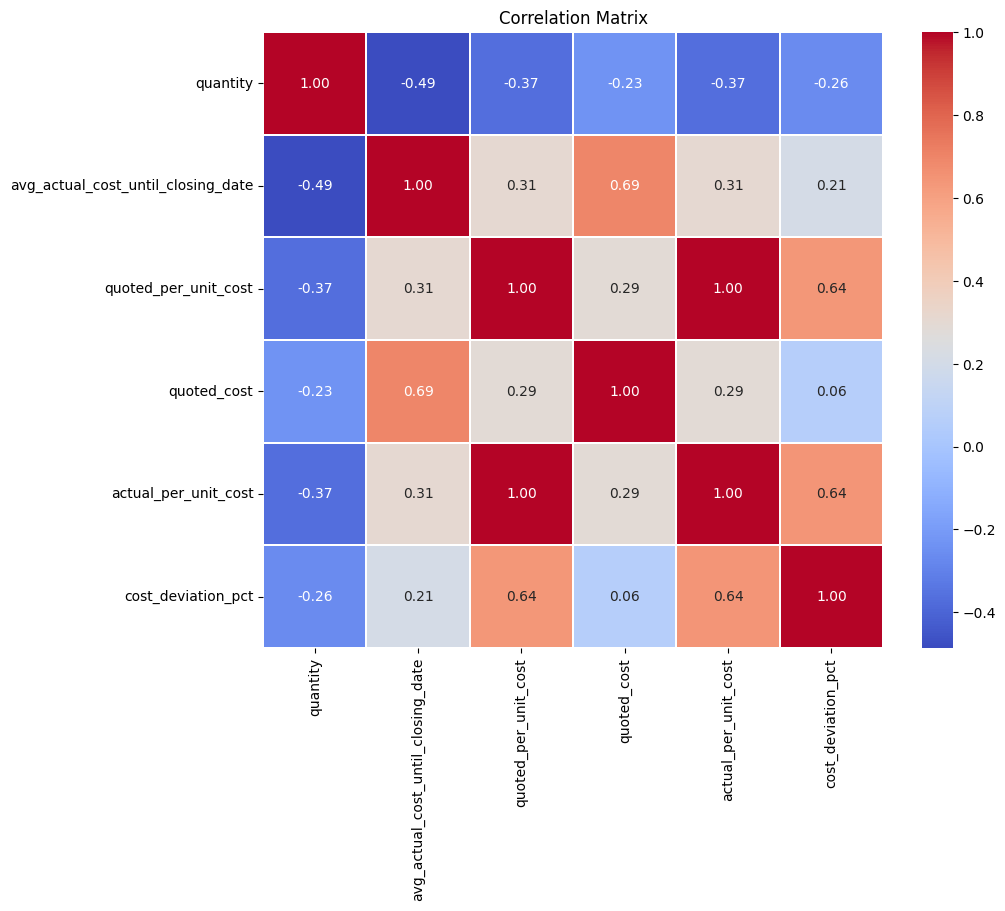

In [0]:
num_matrix = num_target_df.corr()
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(num_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.25)
ax.set_title("Correlation Matrix")

In [0]:
X_cat_encoded = categorical_transformer.fit_transform(X[cat_feat])

In [0]:
cat_target_df = pd.concat([X_cat_encoded, y], axis=1)

Text(0.5, 1.0, 'Correlation Matrix')

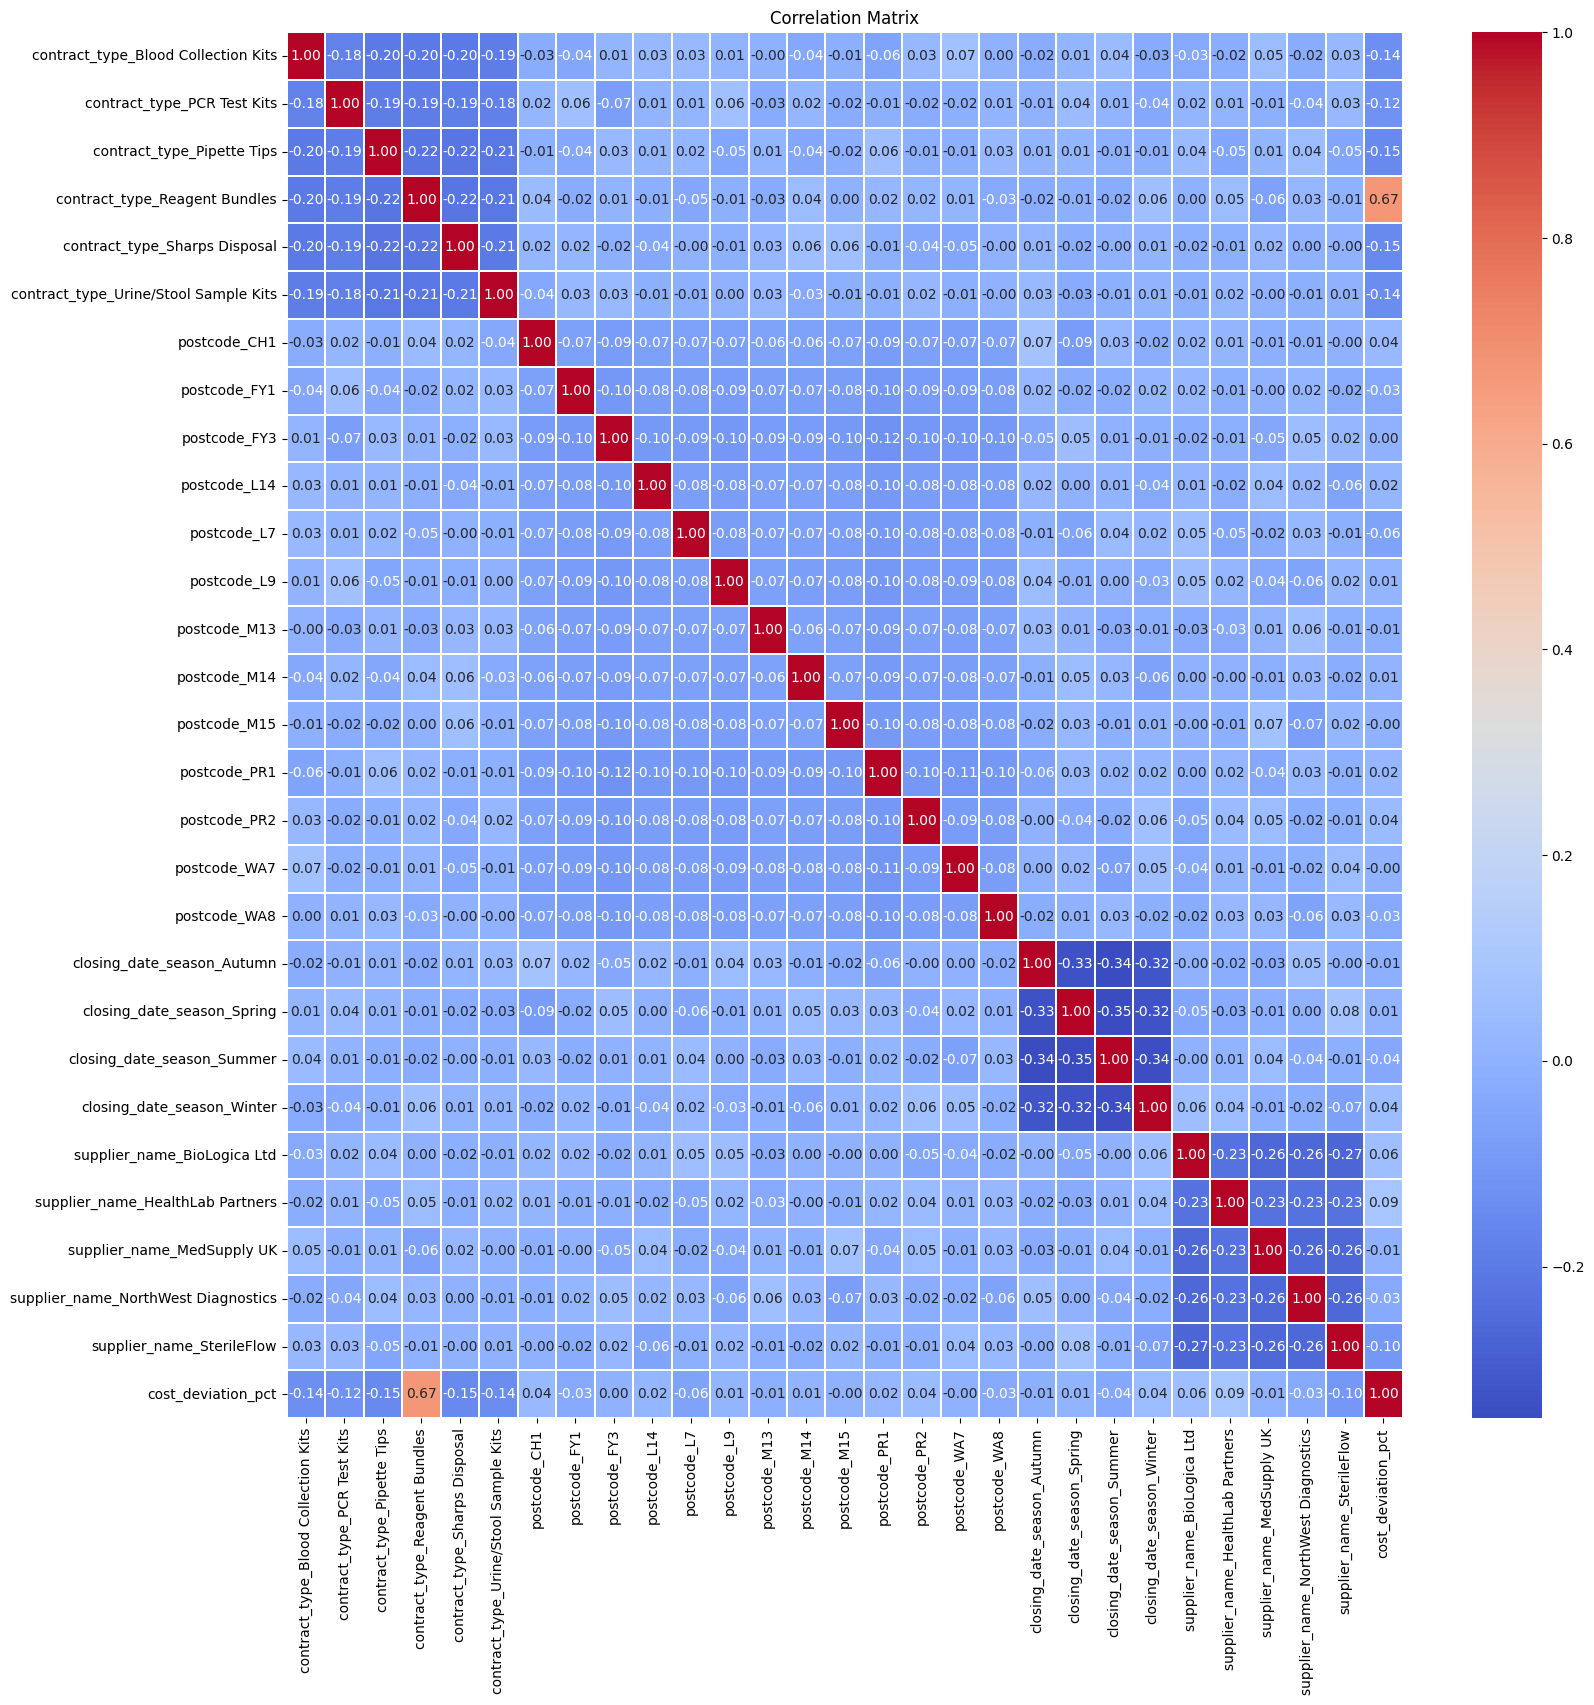

In [0]:
cat_matrix = cat_target_df.corr()
fig,ax = plt.subplots(figsize=(18,18))
sns.heatmap(cat_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.25)
ax.set_title("Correlation Matrix")

Text(0.5, 1.0, 'Correlation Matrix')

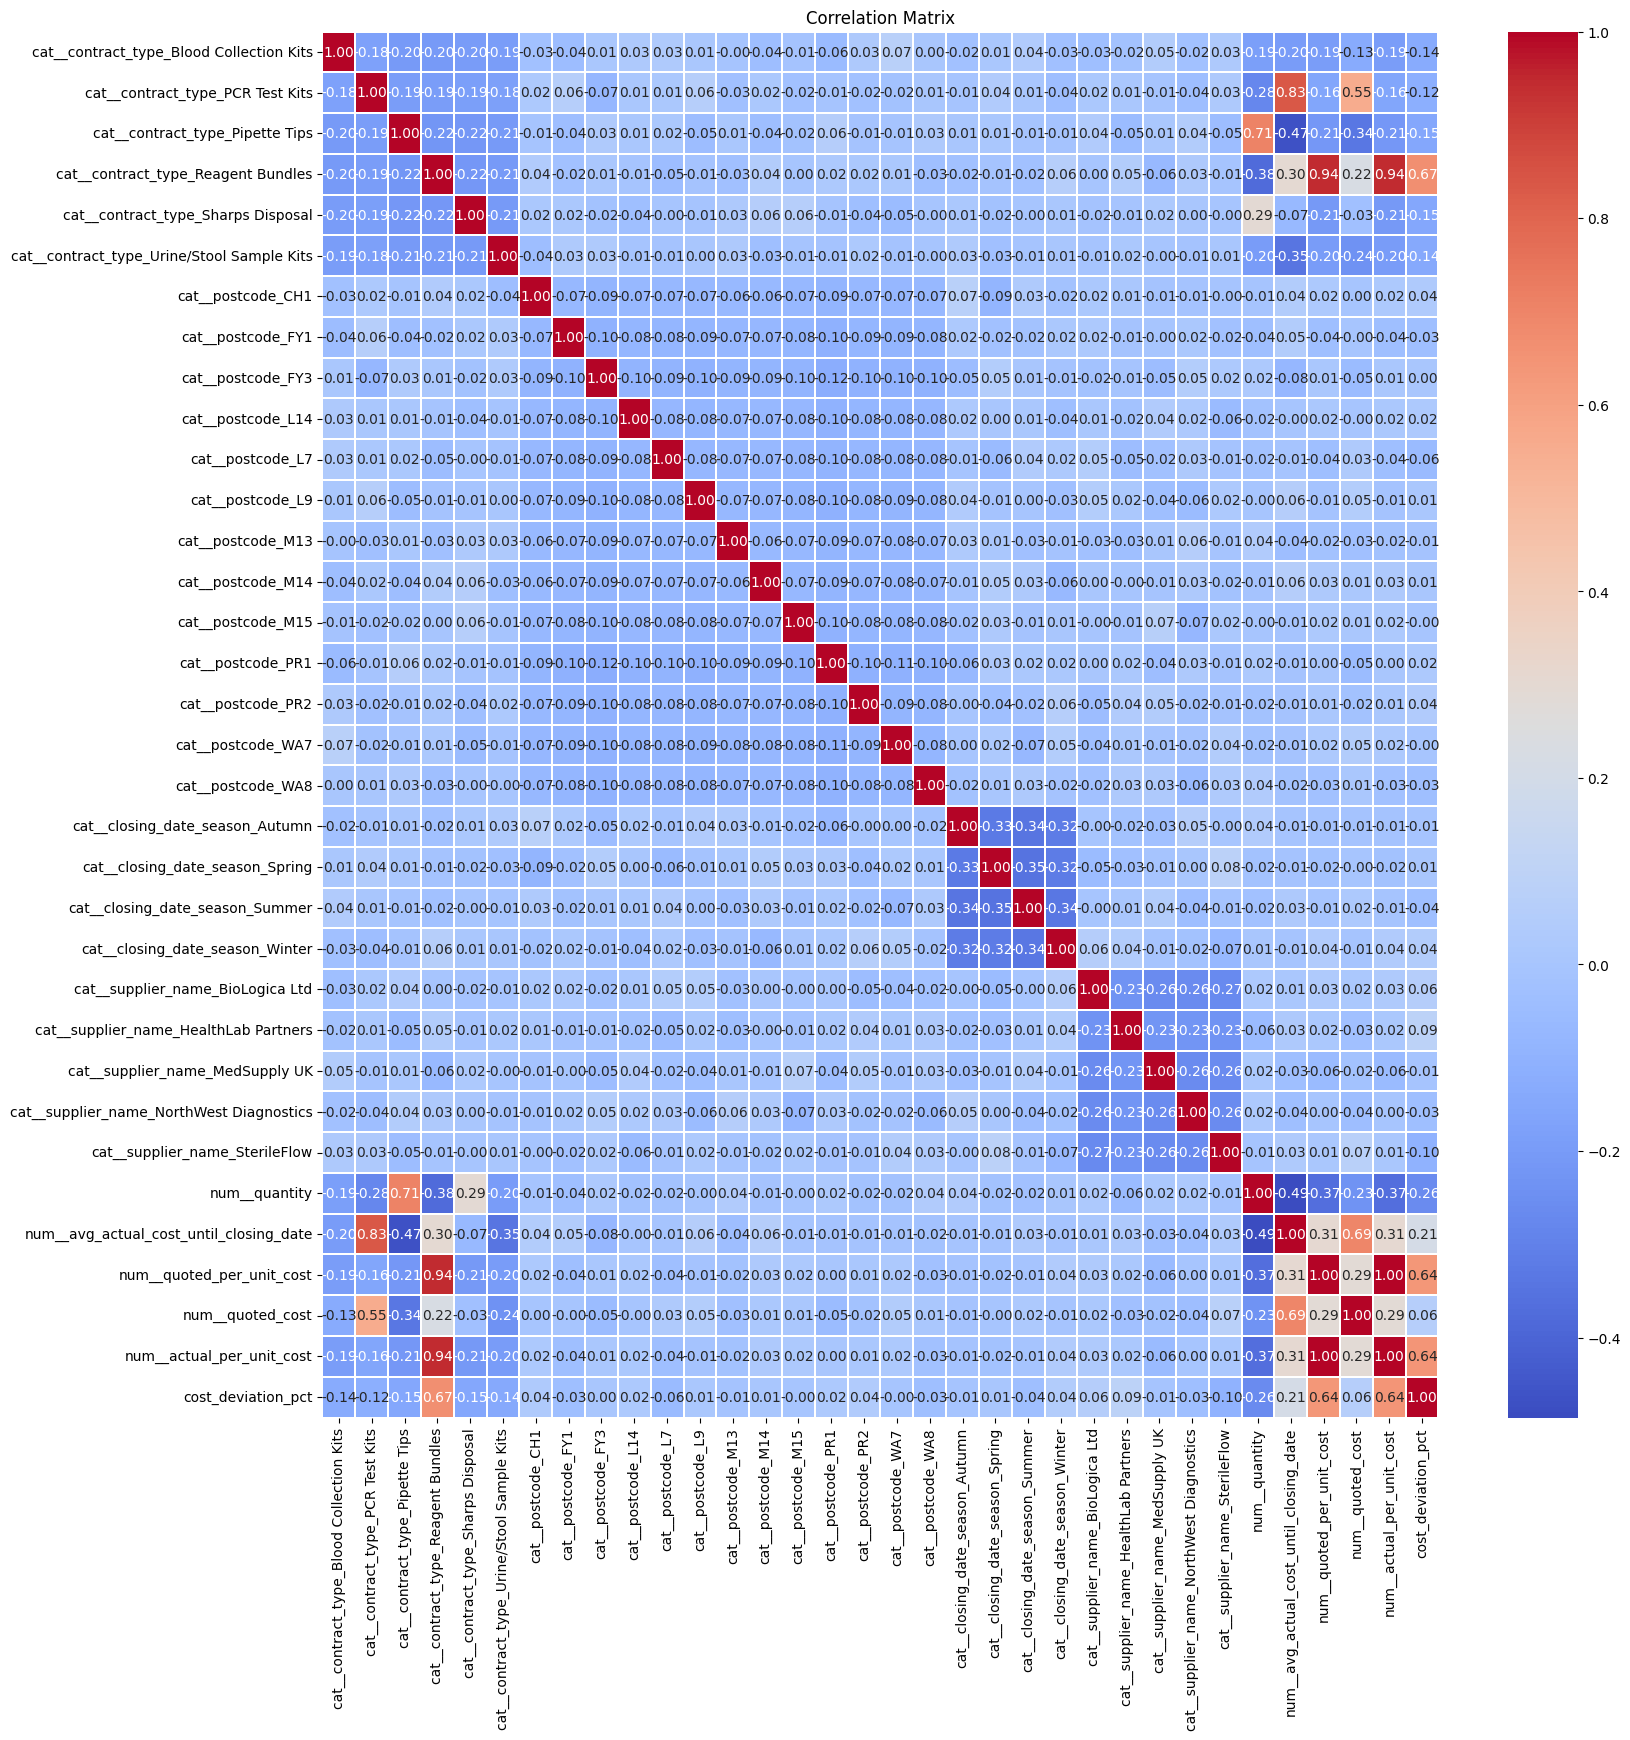

In [0]:
all_df_encoded = preprocessor.fit_transform(X)
all_target_df = pd.concat([all_df_encoded, y], axis=1)
all_matrix = all_target_df.corr()
fig,ax = plt.subplots(figsize=(18,18))
sns.heatmap(all_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.25)
ax.set_title("Correlation Matrix")


In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import PredictionErrorDisplay
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [0]:
nhs_combo_df_pandas.sample()

,contract_id,trust_id,supplier_id,supplier_name,contract_type_id,contract_type,postcode,issue_date,closing_date,trust_name,quoted_lead_days,actual_lead_days,delivery_date,quantity,unit_cost,quoted_cost,actual_cost,cost_overrun,closing_date_month,actual_per_unit_cost,quoted_per_unit_cost,cost_deviation_pct,closing_date_season,avg_actual_cost_until_closing_date
526,NHS-CT-00527,TR-005,SUP-003,NorthWest Diagnostics,CTYP-005,Pipette Tips,FY1,2024-07-18,2024-08-14,Blackpool Teaching Hospitals NHS FT,6,8,2024-08-22,50000,0.08,3886.27,3886.29,0.02,August,0.077726,0.077725,0.000515,Summer,6057.526557


In [0]:
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['contract_type', 'postcode',
                                  'closing_date_season', 'supplier_name']),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['quantity',
                                  'avg_actual_cost_until_closing_date',
                                  'quoted_per_unit_cost', 'quoted_cost',
                                  'actual_per_unit_cost'])])

### Lin regression Model

In [0]:
lin_regr_pp = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("Lin_regr", LinearRegression())
])

In [0]:
lin_regr_pp

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['contract_type', 'postcode',
                                                   'closing_date_season',
                                                   'supplier_name']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['quantity',
                                                   'avg_actual_cost_until_closing_date',
                                                   'quoted_per_unit_cost',
                                                   'quoted_cost',
                                                   'actual_per_unit_cost'])])),
                ('Lin_regr', LinearRegression())])

In [0]:
lin_regr_pp.fit(X_train, y_train)
lin_regr_pp.score(X_test, y_test)

0.9709667908333107

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_preds = lin_regr_pp.predict(X_test)

In [0]:
X_test.columns

Index(['contract_type', 'postcode', 'closing_date_season', 'supplier_name',
       'quantity', 'avg_actual_cost_until_closing_date',
       'quoted_per_unit_cost', 'quoted_cost', 'actual_per_unit_cost'],
      dtype='object')

In [0]:
train_score = lin_regr_pp.score(X_train, y_train)
test_score = lin_regr_pp.score(X_test, y_test)
print(f"Train R2: {train_score:.3f}, Test R2: {test_score:.3f}")

Train R2: 0.958, Test R2: 0.971


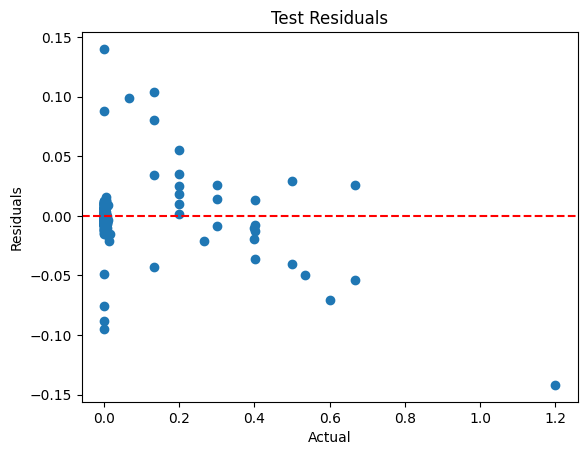

In [0]:
plt.scatter(y_test, y_preds - y_test.values)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title("Test Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [0]:
lin_regr_results_df = pd.DataFrame({"Predicted": y_preds, "Actual": y_test.values, "Residuals": y_test.values - y_preds, "Contract_type": X_test['contract_type']})

overall_lin_test_results_df = pd.DataFrame([{
    "MSE": mean_squared_error(y_test, y_preds),
    "MAE": mean_absolute_error(y_test, y_preds),
    "R2": r2_score(y_test, y_preds),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_preds))
}])

In [0]:
lin_regr_results_df.head(10)

,Predicted,Actual,Residuals,Contract_type
521,0.380955,0.399998,0.019043,Reagent Bundles
737,0.020790,0.004994,-0.015796,PCR Test Kits
740,-0.005425,0.000253,0.005677,Pipette Tips
660,0.005567,0.004951,-0.000616,Urine/Stool Sample Kits
411,-0.007222,0.000803,0.008025,Sharps Disposal
678,0.001911,0.000000,-0.001911,Pipette Tips
626,-0.005413,0.003954,0.009367,Blood Collection Kits
513,0.000472,0.000658,0.000185,Blood Collection Kits
859,0.002560,0.000396,-0.002164,Sharps Disposal
136,0.015351,0.005005,-0.010347,Blood Collection Kits


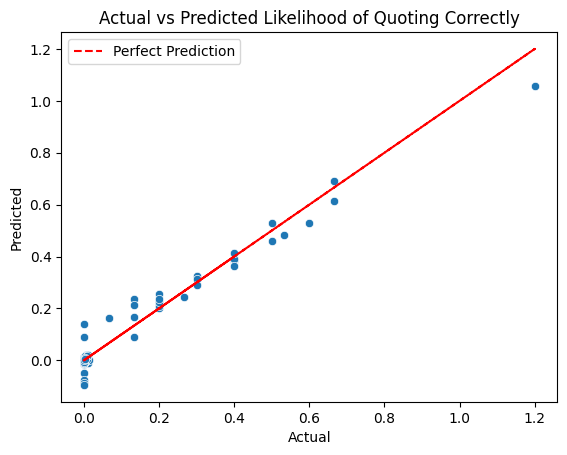

In [0]:
sns.scatterplot(data=lin_regr_results_df, x='Actual', y='Predicted')
plt.plot(lin_regr_results_df['Actual'], lin_regr_results_df['Actual'], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Likelihood of Quoting Correctly")
plt.legend()

Text(0.5, 1.0, 'Residuals by Contract Type')

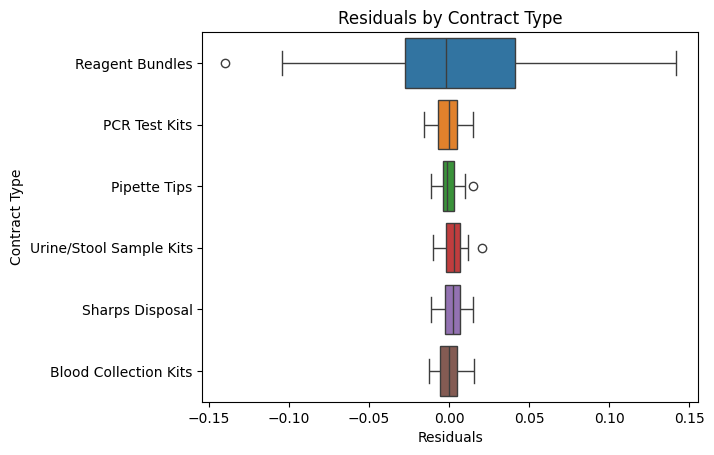

In [0]:
sns.boxplot(y='Contract_type', x='Residuals', data=lin_regr_results_df, hue='Contract_type')
plt.xlabel("Residuals")
plt.ylabel("Contract Type")
plt.title("Residuals by Contract Type")

In [0]:
X_test['contract_type'].value_counts()

contract_type
Pipette Tips               39
Reagent Bundles            35
Sharps Disposal            35
Blood Collection Kits      34
Urine/Stool Sample Kits    32
PCR Test Kits              25
Name: count, dtype: int64

<Axes: xlabel='Actual', ylabel='Predicted'>

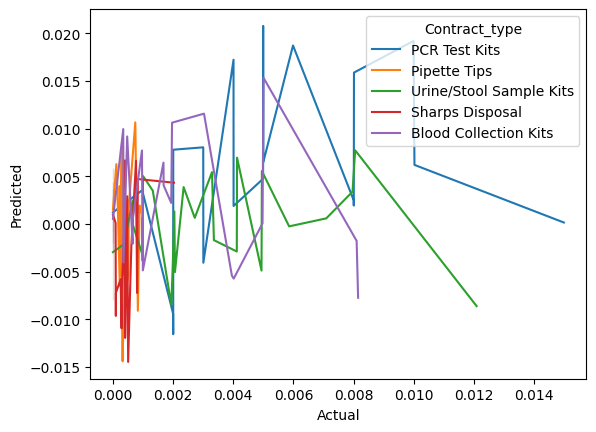

In [0]:
filtered_df = lin_regr_results_df[lin_regr_results_df['Contract_type'] != 'Reagent Bundles']

sns.lineplot(x='Actual', y='Predicted', data=filtered_df, hue='Contract_type')

In [0]:
overall_lin_test_results_df

,MSE,MAE,R2,RMSE
0,0.000662,0.012696,0.970967,0.025735


### Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(lin_regr_pp, X, y, cv=5, scoring='r2')
print(f"CV R2 mean: {cv_scores.mean():.3f}, std: {cv_scores.std():.3f}")

CV R2 mean: 0.955, std: 0.019


### Permutation Importance

In [0]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(lin_regr_pp, X_test, y_test, n_repeats=30, random_state=27, scoring='r2')
# n_repeats = number of times shuffled

In [0]:
perm_importance_df = pd.DataFrame(
    dict(
        feature=X_test.columns,
        pi_mean=perm_importance['importances_mean'],
        pi_std=perm_importance['importances_std']
    )
)

In [0]:
perm_importance_df.sort_values('pi_mean', ascending=False)

,feature,pi_mean,pi_std
6,quoted_per_unit_cost,105150.877332,7457.667637
8,actual_per_unit_cost,105060.285910,7443.371732
0,contract_type,1.397916,0.101896
5,avg_actual_cost_until_closing_date,0.002690,0.000784
4,quantity,0.000022,0.000043
7,quoted_cost,-0.000036,0.000190
3,supplier_name,-0.000262,0.000527
2,closing_date_season,-0.000420,0.000321
1,postcode,-0.000845,0.000769


### PCA + Lin Regr

In [0]:
from sklearn.decomposition import PCA
pca_transformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="mean")),
    ("MinMaxScaler", MinMaxScaler()),
    ("PCA", PCA(n_components=2))
])

pca_pp = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_feat),
        ("num_pca", pca_transformer, num_feat)
    ]
)

In [0]:
pca_lin_regr = Pipeline(steps=[
    ("preprocessor", pca_pp),
    ("Lin_regr", LinearRegression())
])
pca_lin_regr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['contract_type', 'postcode',
                                                   'closing_date_season',
                                                   'supplier_name']),
                                                 ('num_pca',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer()),
                                                                  ('MinMaxScaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=2))]),
                                                  ['quantity',
                                                   'avg_actual_cost_until_closing_date',
                                                   'quoted_per_unit_cost',
                                                   'quoted_cost',
                                                   'actual_per_unit_cost'])])),
                ('Lin_regr', LinearRegression())])

In [0]:
pca_lin_regr.fit(X_train, y_train)
pca_lin_regr.score(X_test, y_test)

0.4478659029157507

### Random Forest Model

In [0]:
from sklearn.ensemble import RandomForestRegressor
rfr_regr_pp = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rfr", RandomForestRegressor(n_estimators=100, max_depth=5, random_state=27))
])

In [0]:
rfr_regr_pp

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['contract_type', 'postcode',
                                                   'closing_date_season',
                                                   'supplier_name']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['quantity',
                                                   'avg_actual_cost_until_closing_date',
                                                   'quoted_per_unit_cost',
                                                   'quoted_cost',
                                                   'actual_per_unit_cost'])])),
                ('rfr', RandomForestRegressor(max_depth=5, random_state=27))])

In [0]:
rfr_regr_pp.fit(X_train, y_train)
rfr_regr_pp.score(X_test, y_test)

0.4374831780305709

In [0]:
pca_rfr_regr = Pipeline(steps=[
    ("preprocessor", pca_pp),
    ("rfr", RandomForestRegressor(n_estimators=100, max_depth=5, random_state=27))
])
pca_rfr_regr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['contract_type', 'postcode',
                                                   'closing_date_season',
                                                   'supplier_name']),
                                                 ('num_pca',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer()),
                                                                  ('MinMaxScaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=2))]),
                                                  ['quantity',
                                                   'avg_actual_cost_until_closing_date',
                                                   'quoted_per_unit_cost',
                                                   'quoted_cost',
                                                   'actual_per_unit_cost'])])),
                ('rfr', RandomForestRegressor(max_depth=5, random_state=27))])

In [0]:
pca_rfr_regr.fit(X_train, y_train)
pca_rfr_regr.score(X_test, y_test)

0.4687083362455092

In [0]:
X_cat_encoded

,contract_type_Blood Collection Kits,contract_type_PCR Test Kits,contract_type_Pipette Tips,contract_type_Reagent Bundles,contract_type_Sharps Disposal,contract_type_Urine/Stool Sample Kits,postcode_CH1,postcode_FY1,postcode_FY3,postcode_L14,postcode_L7,postcode_L9,postcode_M13,postcode_M14,postcode_M15,postcode_PR1,postcode_PR2,postcode_WA7,postcode_WA8,closing_date_season_Autumn,closing_date_season_Spring,closing_date_season_Summer,closing_date_season_Winter,supplier_name_BioLogica Ltd,supplier_name_HealthLab Partners,supplier_name_MedSupply UK,supplier_name_NorthWest Diagnostics,supplier_name_SterileFlow
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [0]:
X_num_encoded

,quantity,avg_actual_cost_until_closing_date,quoted_per_unit_cost,quoted_cost,actual_per_unit_cost
0,0.666556,0.269981,7.180961e-04,0.311055,7.152384e-04
1,0.000667,0.485903,8.951057e-01,0.563481,8.945113e-01
2,0.013004,0.774942,1.735841e-02,0.141261,1.728925e-02
3,0.166389,0.207836,5.307071e-04,0.053144,5.285988e-04
4,0.000167,0.470452,6.125975e-01,0.188666,6.117840e-01
...,...,...,...,...,...
995,0.000167,0.486711,4.152936e-01,0.125869,4.141906e-01
996,0.199733,0.173786,1.826097e-03,0.229953,1.818828e-03
997,0.333111,0.267502,4.327112e-04,0.091814,4.309898e-04
998,0.666556,0.274054,7.181278e-04,0.311069,7.152671e-04


In [0]:
X_train.sample(3)

,contract_type,postcode,closing_date_season,supplier_name,quantity,avg_actual_cost_until_closing_date,quoted_per_unit_cost,quoted_cost,actual_per_unit_cost
592,Urine/Stool Sample Kits,WA8,Summer,BioLogica Ltd,30000,11106.074038,0.738843,22165.28,0.738843
268,Sharps Disposal,M14,Autumn,MedSupply UK,25000,25008.446869,0.299601,7490.02,0.299601
251,Urine/Stool Sample Kits,FY3,Summer,NorthWest Diagnostics,5000,10619.488864,0.672958,3364.79,0.673026


# Predict The Likelihood of Overruning (Predicted Number of Days)

In [0]:
nhs_combo_df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   contract_id                         1000 non-null   object        
 1   trust_id                            1000 non-null   object        
 2   supplier_id                         1000 non-null   object        
 3   supplier_name                       1000 non-null   object        
 4   contract_type_id                    1000 non-null   object        
 5   contract_type                       1000 non-null   object        
 6   postcode                            1000 non-null   object        
 7   issue_date                          1000 non-null   datetime64[ns]
 8   closing_date                        1000 non-null   datetime64[ns]
 9   trust_name                          1000 non-null   object        
 10  quoted_lead_days         